In [4]:
from google.colab import drive
drive.mount("/content/drive")

MessageError: ignored

**Layers of the U-Net model**

In [2]:
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
from tensorflow.keras import backend 
import tensorflow as tf
print(tf.__version__)

#Unet network
def unet_process(resulted_weights = None,input_size = (128,128,1)):
    size_filter_in = 16
    inputs = Input(input_size)
    concat=[0,0,0,0]  # concat=[drop3,conv2,conv1,conv0]
    intermed=inputs
    for i in range(5):
      conv = Conv2D(size_filter_in*(2**i), 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(intermed)
      conv = LeakyReLU()(conv)
      conv = Conv2D(size_filter_in*(2**i), 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)
      conv = LeakyReLU()(conv)
      if i<3:
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
        concat[3-i]=conv
        intermed=pool
      if i==3:
        drop = Dropout(0.5)(conv)
        concat[0]=drop
        pool = MaxPooling2D(pool_size=(2, 2))(drop)
        intermed=pool
      if i==4:
        drop = Dropout(0.5)(conv)
        intermed=drop
        break
  

    for i in range(4):
      up = Conv2D(size_filter_in*(2**(3-i)), 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')
      (UpSampling2D(size = (2,2))(intermed))
      up = LeakyReLU()(up)
      merge = concatenate([concat[i],up], axis = 3)
      conv = Conv2D(size_filter_in*(2**(3-i)), 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge)
      conv = LeakyReLU()(conv)
      conv = Conv2D(size_filter_in*(2**(3-i)), 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv)
      conv = LeakyReLU()(conv)
      intermed=conv

    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(intermed)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)
   
    u_net_model = Model(inputs,conv10)

    u_net_model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])
    
    #model.summary()

    if(resulted_weights):
    	u_net_model.load_weights(resulted_weights)

    return u_net_model

2.7.0


In [ ]:
from scipy import stats

spectrog_path='/content/drive/MyDrive/Colab Notebooks/speech_enhancement/data/train/spectrogram/'

noised_input = np.load(spectrog_path +"noisy_voice_amp.npy")
target = np.load(spectrog_path +'voice_amp.npy') #clean voice
    # noise to predict
noise = noised_input-target

    #Check distribution
print(stats.describe(noised_input.reshape(-1,1)))
print(stats.describe(noise.reshape(-1,1)))
#batch normalisation
    #scale data between -1 and 1
noised_input = (noised_input + 42)/50
noise = (noise -6 )/82

    #Check shape of spectrograms
print(noised_input.shape)
print(noise.shape)
    #Check new distribution
print(stats.describe(noised_input.reshape(-1,1)))
print(stats.describe(noise.reshape(-1,1)))
print(noised_input.shape,noise.shape)


DescribeResult(nobs=95027200, minmax=(array([-80.]), array([0.])), mean=array([-42.65817046]), variance=array([263.63461642]), skewness=array([-0.20247001]), kurtosis=array([-0.31700313]))
DescribeResult(nobs=95027200, minmax=(array([-74.17822608]), array([80.])), mean=array([6.22029277]), variance=array([169.82277164]), skewness=array([1.20450706]), kurtosis=array([1.69538327]))
(5800, 128, 128)
(5800, 128, 128)
DescribeResult(nobs=95027200, minmax=(array([-0.76]), array([0.84])), mean=array([-0.01316341]), variance=array([0.10545385]), skewness=array([-0.20247001]), kurtosis=array([-0.31700313]))
DescribeResult(nobs=95027200, minmax=(array([-0.97778324]), array([0.90243902])), mean=array([0.0026865]), variance=array([0.02525621]), skewness=array([1.20450706]), kurtosis=array([1.69538327]))
(5800, 128, 128) (5800, 128, 128)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
#Reshape for training
X_in = noised_input[:,:,:]
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = noise[:,:,:]
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.1, random_state=42)
weights_path="/content/drive/MyDrive/Colab Notebooks/speech_enhancement/data/weights/"
#from pre-trained weights
gen_nn=unet_process(weights_path+'model_unet.h5',(128,128,1))

#for new training
#generator_nn=unet_process()
#Save to disk
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/speech_enhancement/data-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

gen_nn.summary()
#Training
history = gen_nn.fit(X_train, y_train, epochs=20, batch_size=100, shuffle=True, validation_data=(X_test, y_test),callbacks=[checkpoint], verbose=1)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [ ]:
X_pred_test = generator_nn.predict(X_test)
import matplotlib.pyplot as plt
%matplotlib inline


**Results of the CNN model**

**Comparing predicted spectrogram with the target one**

**Noisy Spectrogram**

In [3]:
id=50
plt.imshow(X_test[id,:,:,0])

NameError: ignored

**Target Spectrogram**

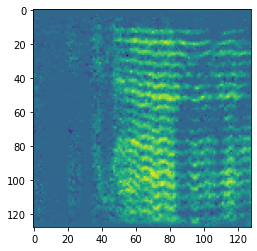

In [ ]:
#TARGET
plt.imshow(y_test[id,:,:,0])



**Predicted Spectrogram**

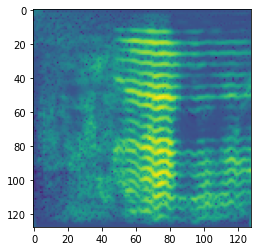

In [ ]:
plt.imshow(X_pred_test[id,:,:,0])


In [ ]:
#Plot training and validation loss
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.yscale('log')
plt.title('Training and validation loss')
plt.legend()
plt.show()

NameError: ignored